In [1]:
'''
=====Experiment=====
Dataset: BoT-IoT dataset

Split train and test subgraph stratigically
Training in chronological window subgraph

IP as node
Encode Ports in raw numbers
'''

from torch_geometric.utils import from_networkx, add_self_loops, degree
from torch_geometric.nn import MessagePassing
import torch_geometric.transforms as T
from torch_geometric.data import DataLoader
from torch_geometric.loader import NeighborSampler
import torch.nn as nn
import torch as th
import torch.nn.functional as F
# import dgl.function as fn
import networkx as nx
import pandas as pd
import socket
import struct
import matplotlib.pyplot as plt
import random
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
# import seaborn as sns
# import matplotlib.pyplot as plt
import numpy as np
import os
import sys
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit
from torch_geometric.loader import DataLoader


project_root = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
sys.path.append(project_root)

from Datasets.BoT_IoT.BoT_IoT_config import BoT_IoT_Config

In [2]:
csv_file_name = "all_raw"

data = pd.read_csv(os.path.join(project_root, "Datasets", f"BoT_IoT/All/{csv_file_name}.csv"))

DATASET_NAME = "BoT_IoT"
EXPERIMENT_NAME = "strat_window_raw_ports_1000"

SOURCE_IP_COL_NAME = BoT_IoT_Config.SOURCE_IP_COL_NAME
DESTINATION_IP_COL_NAME = BoT_IoT_Config.DESTINATION_IP_COL_NAME
SOURCE_PORT_COL_NAME = BoT_IoT_Config.SOURCE_PORT_COL_NAME
DESTINATION_PORT_COL_NAME = BoT_IoT_Config.DESTINATION_PORT_COL_NAME

ATTACK_CLASS_COL_NAME = BoT_IoT_Config.ATTACK_CLASS_COL_NAME
IS_ATTACK_COL_NAME = BoT_IoT_Config.IS_ATTACK_COL_NAME

BENIGN_CLASS_NAME = BoT_IoT_Config.BENIGN_CLASS_NAME

TIME_COLS = BoT_IoT_Config.TIME_COL_NAMES

print(data[ATTACK_CLASS_COL_NAME].value_counts())
print(data[IS_ATTACK_COL_NAME].value_counts())

MULTICLASS = True

if MULTICLASS:
    label_col = ATTACK_CLASS_COL_NAME
    data.drop(columns=[IS_ATTACK_COL_NAME], inplace=True)
else:
    label_col = IS_ATTACK_COL_NAME
    data.drop(columns=[ATTACK_CLASS_COL_NAME], inplace=True)


saves_path = os.path.join(project_root, "Models/E_GraphSAGE/logs", DATASET_NAME, EXPERIMENT_NAME)

checkpoint_path = os.path.join(saves_path, f"checkpoints_{csv_file_name}.pth")
best_model_path = os.path.join(saves_path, f"best_model_{csv_file_name}.pth")

os.makedirs(saves_path, exist_ok=True)

category
DDoS              1926624
DoS               1650260
Reconnaissance      91082
Normal                477
Theft                  79
Name: count, dtype: int64
attack
1    3668045
0        477
Name: count, dtype: int64


In [3]:
ddos_df = data[data[label_col] == 'DDoS']
dos_df = data[data[label_col] == 'DoS']
other_df = data[~data[label_col].isin(['DDoS', 'DoS'])]

# Downsample 90% of DDoS and DoS (keep 10%)
ddos_downsampled = ddos_df.sample(frac=0.1, random_state=42)
dos_downsampled = dos_df.sample(frac=0.1, random_state=42)

# Concatenate the downsampled sets back with the others
data = pd.concat([ddos_downsampled, dos_downsampled, other_df], ignore_index=True)

In [4]:
data.drop(columns=BoT_IoT_Config.DROP_COLS,inplace=True)
print(data.columns)

Index(['pkSeqID', 'stime', 'flgs_number', 'proto_number', 'saddr', 'sport',
       'daddr', 'dport', 'pkts', 'bytes', 'state_number', 'ltime', 'dur',
       'mean', 'stddev', 'sum', 'min', 'max', 'spkts', 'dpkts', 'sbytes',
       'dbytes', 'rate', 'srate', 'drate', 'TnBPSrcIP', 'TnBPDstIP',
       'TnP_PSrcIP', 'TnP_PDstIP', 'TnP_PerProto', 'TnP_Per_Dport',
       'AR_P_Proto_P_SrcIP', 'AR_P_Proto_P_DstIP', 'N_IN_Conn_P_DstIP',
       'N_IN_Conn_P_SrcIP', 'AR_P_Proto_P_Sport', 'AR_P_Proto_P_Dport',
       'Pkts_P_State_P_Protocol_P_DestIP', 'Pkts_P_State_P_Protocol_P_SrcIP',
       'category'],
      dtype='object')


In [5]:
data = pd.get_dummies(data, columns = BoT_IoT_Config.CATEGORICAL_COLS) # One Hot Encoding for categorical data
converted_categorical_cols = [col for col in data.columns if col.startswith(tuple(BoT_IoT_Config.CATEGORICAL_COLS))]

In [6]:
print(data.head)

<bound method NDFrame.head of         pkSeqID         stime            saddr  sport            daddr  dport  \
0       3247076  1.528099e+09  192.168.100.147  15194    192.168.100.3     80   
1       3275257  1.528099e+09  192.168.100.148  60436    192.168.100.3     80   
2       2261058  1.528096e+09  192.168.100.150  29707    192.168.100.3     80   
3       2973625  1.528099e+09  192.168.100.148  62725    192.168.100.3     80   
4       1797107  1.528096e+09  192.168.100.148  40876    192.168.100.3     80   
...         ...           ...              ...    ...              ...    ...   
449321  3668517  1.529381e+09  192.168.100.150  35062    192.168.100.3     22   
449322  3668518  1.529381e+09  192.168.100.150  35064    192.168.100.3     22   
449323  3668519  1.529381e+09  192.168.100.150  35066    192.168.100.3     22   
449324  3668520  1.529381e+09  192.168.100.150  35070    192.168.100.3     22   
449325  3668521  1.529381e+09    192.168.100.3  43001  192.168.100.150   4433  

In [7]:
data = data.reset_index()
data.replace([np.inf, -np.inf], np.nan,inplace = True)
data.fillna(0,inplace = True)
data.drop(columns=['index'],inplace=True)
print(data.head)

<bound method NDFrame.head of         pkSeqID         stime            saddr  sport            daddr  dport  \
0       3247076  1.528099e+09  192.168.100.147  15194    192.168.100.3     80   
1       3275257  1.528099e+09  192.168.100.148  60436    192.168.100.3     80   
2       2261058  1.528096e+09  192.168.100.150  29707    192.168.100.3     80   
3       2973625  1.528099e+09  192.168.100.148  62725    192.168.100.3     80   
4       1797107  1.528096e+09  192.168.100.148  40876    192.168.100.3     80   
...         ...           ...              ...    ...              ...    ...   
449321  3668517  1.529381e+09  192.168.100.150  35062    192.168.100.3     22   
449322  3668518  1.529381e+09  192.168.100.150  35064    192.168.100.3     22   
449323  3668519  1.529381e+09  192.168.100.150  35066    192.168.100.3     22   
449324  3668520  1.529381e+09  192.168.100.150  35070    192.168.100.3     22   
449325  3668521  1.529381e+09    192.168.100.3  43001  192.168.100.150   4433  

In [8]:
scaler = StandardScaler()
cols_to_norm = BoT_IoT_Config.COLS_TO_NORM + [SOURCE_PORT_COL_NAME, DESTINATION_PORT_COL_NAME]
print(data[cols_to_norm].describe()) # Check if there's any too large value

                pkts         bytes            dur           mean  \
count  449326.000000  4.493260e+05  449326.000000  449326.000000   
mean        9.078299  2.730078e+03      19.138468       1.830943   
std       329.626757  3.207773e+05      53.934961       1.617501   
min         1.000000  6.000000e+01       0.000000       0.000000   
25%         3.000000  3.600000e+02       9.580767       0.002634   
50%         6.000000  4.800000e+02      14.197750       2.145157   
75%         8.000000  7.700000e+02      25.799264       3.385247   
max     70057.000000  7.183334e+07    2771.485107       4.981882   

              stddev            sum            min            max  \
count  449326.000000  449326.000000  449326.000000  449326.000000   
mean        0.724100       6.447370       0.839616       2.474417   
std         0.802270      15.739125       1.397493       2.042772   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.003148       

In [9]:
def check_numeric_issues(df, cols_to_norm):
    for col in cols_to_norm:
        try:
            # Try to coerce to numeric
            df[col] = pd.to_numeric(df[col], errors='coerce')
            
            # Try to clip the column
            df[col] = df[col].clip(lower=-1e9, upper=1e9)
            
        except Exception as e:
            print(f"❌ Column '{col}' failed with error: {e}")
            print(f"  - Sample values: {df[col].dropna().unique()[:5]}")
            print(f"  - Data type: {df[col].dtype}")
            continue

    print("\n✅ All other columns processed successfully.")

check_numeric_issues(data, BoT_IoT_Config.COLS_TO_NORM)


✅ All other columns processed successfully.


In [10]:
data[cols_to_norm] = scaler.fit_transform(data[cols_to_norm])

In [11]:
from sklearn.preprocessing import LabelEncoder

num_classes = 2
class_map = [0, 1]
if MULTICLASS:
    le = LabelEncoder()
    attack_labels = le.fit_transform(data[ATTACK_CLASS_COL_NAME])
    class_map = le.classes_
    print(class_map)
    print("Attack label mapping:", dict(zip(class_map, range(len(class_map)))))
    data[ATTACK_CLASS_COL_NAME] = attack_labels
    num_classes = len(class_map)
    class_dict = {le.inverse_transform([i])[0]: i for i in range(len(le.classes_))}

BENIGN_CLASS_LABEL = le.transform([BENIGN_CLASS_NAME])[0] if MULTICLASS else 0
ADVERSARIAL_CLASS_LABEL = len(class_map)

['DDoS' 'DoS' 'Normal' 'Reconnaissance' 'Theft']
Attack label mapping: {'DDoS': 0, 'DoS': 1, 'Normal': 2, 'Reconnaissance': 3, 'Theft': 4}


In [12]:
# # Maintain the order of the rows in the original dataframe

feature_cols = cols_to_norm + converted_categorical_cols

print('Feature Columns:', feature_cols)
num_features = len(feature_cols)
print('Number of Features:', num_features)

data['h'] = data[ feature_cols ].values.tolist()

Feature Columns: ['pkts', 'bytes', 'dur', 'mean', 'stddev', 'sum', 'min', 'max', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'rate', 'srate', 'drate', 'TnBPSrcIP', 'TnBPDstIP', 'TnP_PSrcIP', 'TnP_PDstIP', 'TnP_PerProto', 'TnP_Per_Dport', 'AR_P_Proto_P_SrcIP', 'AR_P_Proto_P_DstIP', 'N_IN_Conn_P_DstIP', 'N_IN_Conn_P_SrcIP', 'AR_P_Proto_P_Sport', 'AR_P_Proto_P_Dport', 'Pkts_P_State_P_Protocol_P_DestIP', 'Pkts_P_State_P_Protocol_P_SrcIP', 'sport', 'dport', 'flgs_number_1', 'flgs_number_2', 'flgs_number_3', 'flgs_number_4', 'flgs_number_5', 'flgs_number_6', 'flgs_number_7', 'flgs_number_8', 'flgs_number_9', 'state_number_1', 'state_number_2', 'state_number_3', 'state_number_4', 'state_number_5', 'state_number_6', 'state_number_7', 'state_number_8', 'state_number_9', 'state_number_10', 'state_number_11', 'proto_number_1', 'proto_number_2', 'proto_number_3', 'proto_number_4', 'proto_number_5']
Number of Features: 56


In [13]:
def create_graph(df):

    G_nx = nx.from_pandas_edgelist(df, SOURCE_IP_COL_NAME, DESTINATION_IP_COL_NAME, ['h', label_col], create_using=nx.MultiDiGraph())
    G_pyg = from_networkx(G_nx)

    num_nodes = G_pyg.num_nodes
    num_edges = G_pyg.num_edges

    G_pyg.x = th.ones(num_nodes, len(df['h'].iloc[0])) 

    edge_attr_list = []
    edge_label_list = []

    for u, v, key, data in G_nx.edges(keys=True, data=True):
        edge_attr_list.append(data['h']) 
        edge_label_list.append(data[label_col]) 

    G_pyg.edge_attr = th.tensor(edge_attr_list, dtype=th.float32)
    G_pyg.edge_label = th.tensor(edge_label_list, dtype=th.long)

    return G_pyg

In [14]:
from collections import defaultdict
from typing import Counter
from sklearn.preprocessing import MultiLabelBinarizer

from tqdm import tqdm

class StratifiedGraphDataset:

    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.total_count = len(self.y)

        # Compute class weights
        labels = []

        for graph in self.X:
            labels.append(graph.edge_label.tolist())

        labels = np.concatenate(labels)

        self.class_counts = Counter(labels)

        # Compute the class weights
        self.class_weights = class_weight.compute_class_weight(
            class_weight='balanced',
            classes=np.unique(labels),
            y=labels
        )

    def k_fold_split(self, k: int = 5, test_ratio: float = 0.15, random_state: int = 42):
        cv = MultilabelStratifiedShuffleSplit(test_size=test_ratio, random_state=random_state, n_splits=k)

        mlb = MultiLabelBinarizer()

        y_binary = mlb.fit_transform(self.y)

        return cv.split(np.zeros(len(self.X)), y_binary)

    def graph_train_test_split(self, test_ratio: float = 0.15, random_state: int = 42):
        train_idx, test_idx = next(self.k_fold_split(k = 1, test_ratio = test_ratio, random_state = random_state))
        
        X_train = [self.X[i] for i in train_idx]
        X_test = [self.X[i] for i in test_idx]

        y_train = [self.y[i] for i in train_idx]
        y_test = [self.y[i] for i in test_idx]

        return StratifiedGraphDataset(X_train, y_train), StratifiedGraphDataset(X_test, y_test)
    
    def print_class_distribution_and_weights(self):
        # Use the label encoder to inverse transform the class labels
        class_counts_named = {cls: count for cls, count in self.class_counts.items()}
        class_weights_named = {cls: weight for cls, weight in enumerate(self.class_weights)}
        print("Class Counts and Weights:")
        for cls_label in class_counts_named.keys():
            count = class_counts_named[cls_label]
            weight = class_weights_named[cls_label]
            print(f"{cls_label:<2}  {le.inverse_transform([cls_label])[0]:<15}: Count = {count:<10}, Weight = {weight:<10.4f}")
    
    def __len__(self):
        return self.total_count

    def __iter__(self):
        for g in self.X:
            yield g
            
    def __getitem__(self, idx):
        if isinstance(idx, int):
            return self.X[idx], self.y[idx]
        elif isinstance(idx, slice):
            return [self.X[i] for i in range(len(self.X))][idx], [self.y[i] for i in range(len(self.y))][idx]
        else:
            raise TypeError("Index must be an integer or a slice.")

def generate_graph_datasets(
    df: pd.DataFrame, 
    window_size: int = 1000, 
    # overlap_ratio: float = 0, 
    feature_cols=feature_cols,
    ordering_cols= TIME_COLS, 
    label_col=label_col,
    build_graph_func=create_graph,
    # downsampler=downsampler
    ):

    print("All Columns: ", df.columns)
    print("Ordering Columns: ", ordering_cols)
    assert all(col in df.columns for col in ordering_cols), "All timestamp columns are required"
    assert label_col in df.columns, "Edge label column 'label' is required"
    
    df = df.sort_values(ordering_cols).reset_index(drop=True)
    window_size = int(window_size)
    
    df.drop(columns=set(df.columns) - set(feature_cols) - set(label_col))

    print("Final Columns: ", df.columns)
    
    label_counts_list = []
    X = []
    y = []

    progress_bar = tqdm(range(0, len(df), window_size), desc=f"Generating graphs")
    for start in progress_bar:
        window_df = df[start: min(start + window_size, len(df))]
        contains_label = window_df[label_col].unique()

        G_pyg = build_graph_func(window_df)

        label_counts = window_df[label_col].value_counts()

        label_counts_list.append(label_counts)
        X.append(G_pyg)
        y.append(contains_label.tolist())

    # X, y = downsampler.downsample(label_counts_list, X, y)
        
    return StratifiedGraphDataset(X, y)

In [15]:
graph_dataset = generate_graph_datasets(data)
full_train_graph_dataset, test_graph_dataset = graph_dataset.graph_train_test_split(test_ratio=0.15, random_state=42)


All Columns:  Index(['pkSeqID', 'stime', 'saddr', 'sport', 'daddr', 'dport', 'pkts', 'bytes',
       'ltime', 'dur', 'mean', 'stddev', 'sum', 'min', 'max', 'spkts', 'dpkts',
       'sbytes', 'dbytes', 'rate', 'srate', 'drate', 'TnBPSrcIP', 'TnBPDstIP',
       'TnP_PSrcIP', 'TnP_PDstIP', 'TnP_PerProto', 'TnP_Per_Dport',
       'AR_P_Proto_P_SrcIP', 'AR_P_Proto_P_DstIP', 'N_IN_Conn_P_DstIP',
       'N_IN_Conn_P_SrcIP', 'AR_P_Proto_P_Sport', 'AR_P_Proto_P_Dport',
       'Pkts_P_State_P_Protocol_P_DestIP', 'Pkts_P_State_P_Protocol_P_SrcIP',
       'category', 'flgs_number_1', 'flgs_number_2', 'flgs_number_3',
       'flgs_number_4', 'flgs_number_5', 'flgs_number_6', 'flgs_number_7',
       'flgs_number_8', 'flgs_number_9', 'state_number_1', 'state_number_2',
       'state_number_3', 'state_number_4', 'state_number_5', 'state_number_6',
       'state_number_7', 'state_number_8', 'state_number_9', 'state_number_10',
       'state_number_11', 'proto_number_1', 'proto_number_2', 'proto_number_

Generating graphs: 100%|██████████| 450/450 [00:18<00:00, 24.00it/s]


In [16]:
print("Class Distrubution:", data[label_col].value_counts())

print("Number of graphs after downsampling:", len(graph_dataset))
graph_dataset.print_class_distribution_and_weights()
print("Number of training graphs:", len(full_train_graph_dataset))
full_train_graph_dataset.print_class_distribution_and_weights()
print("Number of testing graphs:", len(test_graph_dataset))
test_graph_dataset.print_class_distribution_and_weights()

Class Distrubution: category
0    192662
1    165026
3     91082
2       477
4        79
Name: count, dtype: int64
Number of graphs after downsampling: 450
Class Counts and Weights:
2   Normal         : Count = 477       , Weight = 188.3966  
3   Reconnaissance : Count = 91082     , Weight = 0.9866    
1   DoS            : Count = 165026    , Weight = 0.5446    
0   DDoS           : Count = 192662    , Weight = 0.4664    
4   Theft          : Count = 79        , Weight = 1137.5342 
Number of training graphs: 383
Class Counts and Weights:
2   Normal         : Count = 416       , Weight = 183.8106  
3   Reconnaissance : Count = 77143     , Weight = 0.9912    
1   DoS            : Count = 140441    , Weight = 0.5445    
0   DDoS           : Count = 164247    , Weight = 0.4656    
4   Theft          : Count = 79        , Weight = 967.9139  
Number of testing graphs: 67
Class Counts and Weights:
3   Reconnaissance : Count = 13939     , Weight = 1.2017    
2   Normal         : Count = 61    

In [17]:
class SAGELayerPyG(MessagePassing):
    def __init__(self, in_channels, edge_dim, out_channels, activation=F.relu):
        super().__init__(aggr='mean')  # mean aggregation
        self.W_msg = nn.Linear(in_channels + edge_dim, out_channels)
        self.W_apply = nn.Linear(in_channels + out_channels, out_channels)
        self.activation = activation

    def forward(self, x, edge_index, edge_attr):
        # x: [num_nodes, in_channels]
        # edge_attr: [num_edges, edge_dim]
        return self.propagate(edge_index, x=x, edge_attr=edge_attr)

    def message(self, x_j, edge_attr):
        # x_j: features of source nodes (neighbours)
        msg_input = th.cat([x_j, edge_attr], dim=1)
        return self.W_msg(msg_input)

    def update(self, aggr_out, x):
        # aggr_out: [num_nodes, out_channels]
        combined = th.cat([x, aggr_out], dim=1)
        out = self.W_apply(combined)
        return self.activation(out)
    
class MLPPredictor(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(MLPPredictor, self).__init__()
        self.lin = nn.Linear(in_channels * 2, out_channels)

    def forward(self, data, z):
        row, col = data.edge_index
        # Concatenate the features of source and target nodes for each edge
        edge_feat = th.cat([z[row], z[col]], dim=1)
        return self.lin(edge_feat)

class EGraphSAGE(nn.Module):
    def __init__(self, node_in_channels, edge_in_channels, hidden_channels, out_channels, dropout=0.2):
        super(EGraphSAGE, self).__init__()
        self.dropout = dropout
        self.conv1 = SAGELayerPyG(node_in_channels, edge_in_channels, hidden_channels)
        self.conv2 = SAGELayerPyG(hidden_channels, edge_in_channels, hidden_channels)
        self.mlp_predictor = MLPPredictor(hidden_channels, out_channels)

    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        x = F.relu(self.conv1(x, edge_index, edge_attr))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index, edge_attr)
        return self.mlp_predictor(data, x)

In [18]:
device = th.device("cuda:0" if th.cuda.is_available() else "cpu")
print(device)

cuda:0


In [19]:
th.cuda.empty_cache()

In [20]:


def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        nn.init.constant_(m.bias, 0)



In [21]:
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold

def compute_accuracy(pred, labels):
    return (pred.argmax(1) == labels).float().mean().item()

def grid_search(graph_dataset, epochs, learning_rates, hidden_dims, folds=3):
    global num_features
    
    best_params = {}
    best_f1 = 0

    # Precompute the train and validation graphs for all folds
    folds_list = []
    for i in range(folds):
        train_graph_dataset, val_graph_dataset = graph_dataset.graph_train_test_split(test_ratio=0.15, random_state=i)
        folds_list.append((train_graph_dataset, val_graph_dataset))

    params_results = {}
    for lr in learning_rates:
        for hidden_dim in hidden_dims:
            for drop_out in drop_outs:
                print(f"Testing with learning rate: {lr}, hidden_dim: {hidden_dim}")
                fold_f1_scores = []

                for fold, (train_graph_dataset, val_graph_dataset) in enumerate(folds_list):
                    print(f"Fold {fold + 1}")

                    model = EGraphSAGE(node_in_channels=num_features,
                                    edge_in_channels=num_features,
                                    hidden_channels=hidden_dim,
                                    dropout = drop_out,
                                    out_channels=num_classes).to(device)

                    model.apply(init_weights)

                    # Normalize to stabilize training
                    class_weights = th.FloatTensor(train_graph_dataset.class_weights).to(device)
                    print("Class weights:", class_weights)

                    criterion = nn.CrossEntropyLoss(weight=class_weights)
                    optimizer = th.optim.Adam(model.parameters(), lr=lr)
                    scheduler = th.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=1e-6)

                    best_epoch_f1 = 0  # Track the best F1 score for this fold

                    for epoch in range(epochs):
                        try:
                            total_train_loss = 0
                            total_val_loss = 0

                            model.train()
                            for G_pyg_train in tqdm(train_graph_dataset, desc="Training", leave=False):
                                G_pyg_train = G_pyg_train.to(device)

                                G_pyg_train.edge_label = G_pyg_train.edge_label.to(device)
                                G_pyg_train.edge_attr = G_pyg_train.edge_attr.to(device)
                                
                                out = model(G_pyg_train)
                                loss = criterion(out, G_pyg_train.edge_label)
                                total_train_loss += loss.item()

                                optimizer.zero_grad()
                                loss.backward()

                                optimizer.step()
                                scheduler.step()
                            
                            model.eval()

                            test_label_list = []
                            pred_label_list = []

                            with th.no_grad():
                                for G_pyg_val in tqdm(val_graph_dataset, desc="Validation", leave=False):

                                    G_pyg_val.to(device)
                                    G_pyg_val.edge_label = G_pyg_val.edge_label.to(device)
                                    G_pyg_val.edge_attr = G_pyg_val.edge_attr.to(device)

                                    out = model(G_pyg_val)
                                    loss = criterion(out, G_pyg_val.edge_label)
                                    total_val_loss += loss.item()

                            test_label = th.cat(test_label_list)
                            pred_label = th.cat(pred_label_list)

                            val_f1 = f1_score(test_label.cpu(), pred_label.cpu(), average='weighted')

                            if val_f1 > best_epoch_f1:
                                best_epoch_f1 = val_f1  # Update the best F1 score for this fold
                                print(f"Best F1 Score at epoch {epoch}: {best_epoch_f1:.4f}, Train Loss: {total_train_loss:.4f}, Validation Loss: {total_val_loss:.4f}, Parameters: lr={lr}, hidden_dim={hidden_dim}, drop_out={drop_out}")

                            print(f'Epoch {epoch}, Train Loss: {total_train_loss:.4f}, Validation Loss: {total_val_loss:.4f}, Validation F1: {avg_f1:.4f}')

                        except Exception as e:
                            print(f"An error occurred at epoch {epoch}: {str(e)}")
                            break

                    fold_f1_scores.append(best_epoch_f1)  # Append the best F1 score for this fold
                
                avg_f1 = sum(fold_f1_scores) / len(fold_f1_scores)
                params_results[(drop_out, lr, hidden_dim)] = {'folds': fold_f1_scores, 'avg_f1': avg_f1}
                print(f"Average F1 Score for drop_out {drop_out}, learning rate {lr}, hidden_dim {hidden_dim}: {avg_f1:.4f}")

                if avg_f1 > best_f1:
                    best_f1 = avg_f1
                    best_params = {'learning_rate': lr, 'hidden_dim': hidden_dim, 'drop_out': drop_out}

    print(f"Best Parameters: {best_params}, Best F1 Score: {best_f1:.4f}")
    print("All results:", params_results)


learning_rates = [0.001, 0.005, 0.01, 0.05]
hidden_dims = [128, 256, 512]
drop_outs = [0.2, 0.3, 0.4]

# grid_search(full_train_graph_dataset, epochs=10, learning_rates=learning_rates, hidden_dims=hidden_dims, drop_outs=drop_outs)


In [22]:
train_graph_dataset, val_graph_dataset = full_train_graph_dataset.graph_train_test_split(test_ratio=0.15, random_state=42)

In [23]:
import pickle

def save_progress(epoch, model, optimizer, scheduler, best_f1, train_loss_history, val_loss_history, val_f1_history, saved_model_epochs):
    global checkpoint_path, train_loss_history_path, val_loss_history_path, val_f1_history_path, saved_model_epochs_path

    # Save checkpoint
    th.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'best_f1': best_f1
    }, checkpoint_path)
    with open(train_loss_history_path, 'wb') as f:
        pickle.dump(train_loss_history, f)
    with open(val_loss_history_path, 'wb') as f:
        pickle.dump(val_loss_history, f)
    with open(val_f1_history_path, 'wb') as f:
        pickle.dump(val_f1_history, f)
    with open(saved_model_epochs_path, 'wb') as f:
        pickle.dump(saved_model_epochs, f)

In [24]:
# Extract the best parameters from the grid search
import pickle

best_hidden_dim = 256  # Replace with the best hidden_dim found
best_learning_rate = 0.01  # Replace with the best learning_rate found
best_drop_out = 0.3  # Replace with the best drop_out found
epochs = 200

print("Number of train graphs: ", len(train_graph_dataset))

# Initialize the model with the best parameters
model = EGraphSAGE(node_in_channels=num_features, 
                   edge_in_channels=num_features,
                   hidden_channels=best_hidden_dim,
                   dropout = best_drop_out,
                   out_channels=num_classes).to(device)

model.apply(init_weights)

# Normalize class weights
class_weights = th.FloatTensor(train_graph_dataset.class_weights).to(device)
print("Class weights:", class_weights)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = th.optim.Adam(model.parameters(), lr=best_learning_rate)
scheduler = th.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=1e-6)

# ===== Load checkpoint if exists =====
best_f1 = 0
start_epoch = 0

if os.path.exists(checkpoint_path):
    checkpoint = th.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    best_f1 = checkpoint['best_f1']
    print(f"Resumed training from epoch {start_epoch}")

train_loss_history = []
val_loss_history = []
val_f1_history = []
saved_model_epochs = []

train_loss_history_path = os.path.join(saves_path, 'train_loss_history.pkl')
val_loss_history_path = os.path.join(saves_path, 'val_loss_history.pkl')
val_f1_history_path = os.path.join(saves_path, 'val_f1_history.pkl')
saved_model_epochs_path = os.path.join(saves_path, 'saved_model_epochs.pkl')

if os.path.exists(train_loss_history_path) and os.path.exists(val_loss_history_path) and os.path.exists(val_f1_history_path) and os.path.exists(saved_model_epochs_path):
    with open(train_loss_history_path, 'rb') as f:
        train_loss_history = pickle.load(f)
    with open(val_loss_history_path, 'rb') as f:
        val_loss_history = pickle.load(f)
    with open(val_f1_history_path, 'rb') as f:
        val_f1_history = pickle.load(f)
    with open(saved_model_epochs_path, 'rb') as f:
        saved_model_epochs = pickle.load(f)

# ===== Start Training =====
for epoch in range(start_epoch, epochs):
    model.train()

    train_loss = 0
    num_train_graphs = len(train_graph_dataset)

    val_loss = 0
    num_val_graphs = len(val_graph_dataset)

    optimizer.zero_grad()
    for G_pyg_train in tqdm(train_graph_dataset, desc="Training", leave=False):

        # Move the graph data to the device
        G_pyg_train = G_pyg_train.to(device)
        G_pyg_train.edge_label = G_pyg_train.edge_label.to(device)
        G_pyg_train.edge_attr = G_pyg_train.edge_attr.to(device)

        out = model(G_pyg_train)
        loss = criterion(out, G_pyg_train.edge_label) / num_train_graphs
        
        train_loss += loss.item()
        loss.backward()

    optimizer.step()
    scheduler.step()

    test_label_list = []
    pred_label_list = []

    model.eval()
    with th.no_grad():
        for G_pyg_val in tqdm(val_graph_dataset, desc="Evaluation", leave=False):
            G_pyg_val = G_pyg_val.to(device)
            G_pyg_val.edge_label = G_pyg_val.edge_label.to(device)
            G_pyg_val.edge_attr = G_pyg_val.edge_attr.to(device)

            out = model(G_pyg_val)
            loss = criterion(out, G_pyg_val.edge_label) / num_val_graphs
            val_loss += loss.item()

            test_label_list.append(G_pyg_val.edge_label.cpu())
            pred_label_list.append(out.argmax(dim=1).cpu())

    test_label = th.cat(test_label_list)
    pred_label = th.cat(pred_label_list)

    val_f1 = f1_score(test_label, pred_label, average='weighted')
    val_f1_micro = f1_score(test_label, pred_label, average='micro')
    val_f1_macro = f1_score(test_label, pred_label, average='macro')
    
    train_loss_history.append(train_loss)
    val_loss_history.append(val_loss)
    val_f1_history.append((val_f1, val_f1_micro, val_f1_macro))

    if val_f1 > best_f1:
        best_f1 = val_f1  # Update the best F1 score for this fold
        best_model_state = model.state_dict()
        saved_model_epochs.append(epoch)

        save_progress(epoch, model, optimizer, scheduler, best_f1, train_loss_history, val_loss_history, val_f1_history, saved_model_epochs)
        th.save(best_model_state, best_model_path)
        print(f"Epoch {epoch} Saved best model. Best F1:", best_f1)

    if epoch % 10 == 0:
        # Save checkpoint
        print(f'Epoch {epoch}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation F1: {val_f1:.4f}')
        save_progress(epoch, model, optimizer, scheduler, best_f1, train_loss_history, val_loss_history, val_f1_history, saved_model_epochs)

# Save the trained model
end_epoch = epochs
save_progress(end_epoch, model, optimizer, scheduler, best_f1, train_loss_history, val_loss_history, val_f1_history, saved_model_epochs)
print("Model training completed and saved.")

Number of train graphs:  325
Class weights: tensor([4.6583e-01, 5.4307e-01, 1.7297e+02, 9.9511e-01, 8.2108e+02],
       device='cuda:0')


Epoch 0 Saved best model. Best F1: 0.284104606876142
Epoch 0, Train Loss: 1.9743, Validation Loss: 2.6229, Validation F1: 0.2841


Epoch 1 Saved best model. Best F1: 0.32546888711011224


Epoch 3 Saved best model. Best F1: 0.44032857800121233


Epoch 6 Saved best model. Best F1: 0.46110988295937855


Epoch 9 Saved best model. Best F1: 0.7336347723267207


Epoch 10, Train Loss: 0.6618, Validation Loss: 0.7430, Validation F1: 0.4333


Epoch 11 Saved best model. Best F1: 0.7845768934510908


Epoch 13 Saved best model. Best F1: 0.8049544815047421


Epoch 14 Saved best model. Best F1: 0.9126581083192263


Epoch 16 Saved best model. Best F1: 0.9207290420937632


Epoch 20 Saved best model. Best F1: 0.9324580497949185
Epoch 20, Train Loss: 0.2750, Validation Loss: 0.2000, Validation F1: 0.9325


Epoch 21 Saved best model. Best F1: 0.9385897990512432


Epoch 22 Saved best model. Best F1: 0.9386307235903041


Epoch 23 Saved best model. Best F1: 0.9445357062136551


Epoch 24 Saved best model. Best F1: 0.9580537701046488


Epoch 25 Saved best model. Best F1: 0.965645926439812


Epoch 29 Saved best model. Best F1: 0.9791714610929134


Epoch 30, Train Loss: 0.0608, Validation Loss: 0.0889, Validation F1: 0.9792


Epoch 34 Saved best model. Best F1: 0.9793925902776923


Epoch 35 Saved best model. Best F1: 0.979410072554004


Epoch 37 Saved best model. Best F1: 0.9966701750990504


Epoch 38 Saved best model. Best F1: 0.9995601489111421


Epoch 40, Train Loss: 0.0334, Validation Loss: 0.0393, Validation F1: 0.9995


Epoch 50, Train Loss: 0.0128, Validation Loss: 0.0238, Validation F1: 0.9995


Epoch 51 Saved best model. Best F1: 0.9996831369379487


Epoch 60, Train Loss: 0.0083, Validation Loss: 0.0298, Validation F1: 0.9829


Epoch 70, Train Loss: 0.0069, Validation Loss: 0.0307, Validation F1: 0.9828


Epoch 80, Train Loss: 0.0057, Validation Loss: 0.0357, Validation F1: 0.9829


Epoch 90, Train Loss: 0.0054, Validation Loss: 0.0362, Validation F1: 0.9829


Epoch 100, Train Loss: 0.0046, Validation Loss: 0.0344, Validation F1: 0.9829


Epoch 110, Train Loss: 0.0043, Validation Loss: 0.0330, Validation F1: 0.9829


Epoch 120, Train Loss: 0.0042, Validation Loss: 0.0338, Validation F1: 0.9829


Epoch 130, Train Loss: 0.0040, Validation Loss: 0.0357, Validation F1: 0.9829


Epoch 140, Train Loss: 0.0045, Validation Loss: 0.0351, Validation F1: 0.9829


Epoch 150, Train Loss: 0.0041, Validation Loss: 0.0347, Validation F1: 0.9829


Epoch 160, Train Loss: 0.0043, Validation Loss: 0.0351, Validation F1: 0.9829


Epoch 170, Train Loss: 0.0043, Validation Loss: 0.0352, Validation F1: 0.9829


Epoch 180, Train Loss: 0.0041, Validation Loss: 0.0352, Validation F1: 0.9829


Epoch 190, Train Loss: 0.0039, Validation Loss: 0.0351, Validation F1: 0.9829


Model training completed and saved.


In [25]:
def plot_training_process(train_losses, val_losses, val_f1, saved_model_epochs):
    fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

    # Plot Train Loss
    axs[0].plot(train_losses, label='Train Loss', color='blue')
    axs[0].plot(val_losses, label='Validation Loss', color='red')
    axs[0].set_ylabel('Train Loss')
    axs[0].set_title('Training Loss')
    axs[0].legend()
    axs[0].grid()

    val_f1_weighted_history = []
    val_f1_micro_history = []
    val_f1_macro_history = []

    for val_f1_weighted, val_f1_micro, val_f1_macro in val_f1:
        val_f1_weighted_history.append(val_f1_weighted)
        val_f1_micro_history.append(val_f1_micro)
        val_f1_macro_history.append(val_f1_macro)
    
    # Plot Validation F1

    axs[1].plot(val_f1_weighted_history, label='Validation F1 Weighted', color='green')
    axs[1].plot(val_f1_micro_history, label='Validation F1 Micro', color='blue')
    axs[1].plot(val_f1_macro_history, label='Validation F1 Macro', color='red')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Validation F1')
    axs[1].set_title('Validation F1 Score')
    axs[1].legend()
    axs[1].grid()

    # Add scatter for saved model epochs (e.g., F1 weighted here)
    axs[1].scatter(saved_model_epochs, [val_f1_weighted_history[i] for i in saved_model_epochs],
                   color='black', marker='o', label='Saved Model')
    axs[1].legend()

    print(len(train_losses))

    plt.tight_layout()
    plt.show()

200


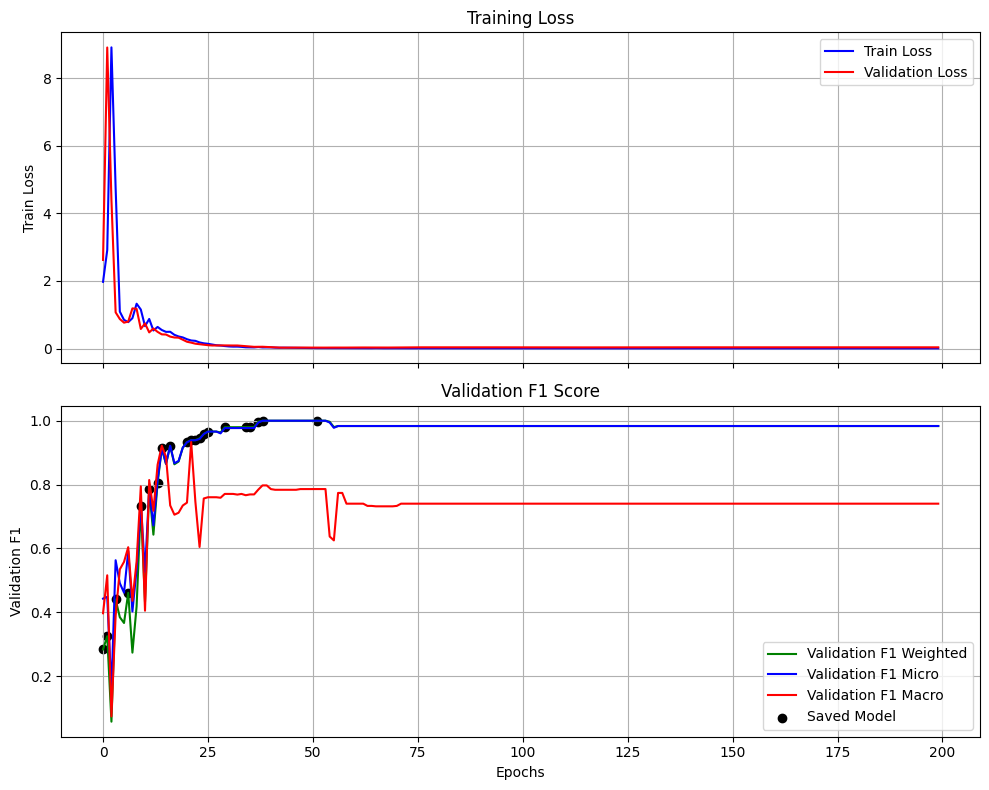

In [26]:
plot_training_process(train_loss_history, val_loss_history, val_f1_history, saved_model_epochs)

In [27]:
import torch
from torch_geometric.utils import degree
from collections import defaultdict

def check_global_avg_degrees_per_class(graph_dataset):
    # Dictionaries to hold total degree sums and counts per class
    total_out_deg = defaultdict(float)
    total_in_deg = defaultdict(float)
    count_out_nodes = defaultdict(int)
    count_in_nodes = defaultdict(int)
    min_out_deg = defaultdict(lambda: float('inf'))
    max_out_deg = defaultdict(lambda: float('-inf'))
    min_in_deg = defaultdict(lambda: float('inf'))
    max_in_deg = defaultdict(lambda: float('-inf'))

    for graph in graph_dataset:
        edge_index = graph.edge_index
        edge_label = graph.edge_label
        num_nodes = graph.num_nodes

        unique_classes = torch.unique(edge_label)

        for cls in unique_classes:
            cls = int(cls)
            mask = (edge_label == cls)

            src_nodes = edge_index[0][mask]
            dst_nodes = edge_index[1][mask]

            out_deg = degree(src_nodes, num_nodes=num_nodes)
            in_deg = degree(dst_nodes, num_nodes=num_nodes)

            involved_src = out_deg > 0
            involved_dst = in_deg > 0

            total_out_deg[cls] += out_deg[involved_src].sum().item()
            total_in_deg[cls] += in_deg[involved_dst].sum().item()
            count_out_nodes[cls] += involved_src.sum().item()
            count_in_nodes[cls] += involved_dst.sum().item()

            if involved_src.any():
                min_out_deg[cls] = min(min_out_deg[cls], out_deg[involved_src].min().item())
                max_out_deg[cls] = max(max_out_deg[cls], out_deg[involved_src].max().item())
            if involved_dst.any():
                min_in_deg[cls] = min(min_in_deg[cls], in_deg[involved_dst].min().item())
                max_in_deg[cls] = max(max_in_deg[cls], in_deg[involved_dst].max().item())

    print("Average, Min, and Max Degrees Across All Graphs:")
    for cls in sorted(total_out_deg.keys()):
        avg_out = total_out_deg[cls] / count_out_nodes[cls] if count_out_nodes[cls] > 0 else 0.0
        avg_in = total_in_deg[cls] / count_in_nodes[cls] if count_in_nodes[cls] > 0 else 0.0
        min_out = min_out_deg[cls] if min_out_deg[cls] != float('inf') else 0.0
        max_out = max_out_deg[cls] if max_out_deg[cls] != float('-inf') else 0.0
        min_in = min_in_deg[cls] if min_in_deg[cls] != float('inf') else 0.0
        max_in = max_in_deg[cls] if max_in_deg[cls] != float('-inf') else 0.0

        print(f"  Attack Class {le.inverse_transform([cls])}:")
        print(f"    Avg Out-Degree (src): {avg_out:.4f} | Min: {min_out:.0f} | Max: {max_out:.0f}")
        print(f"    Avg In-Degree (dst): {avg_in:.4f} | Min: {min_in:.0f} | Max: {max_in:.0f}")

check_global_avg_degrees_per_class(graph_dataset)

Average, Min, and Max Degrees Across All Graphs:
  Attack Class ['DDoS']:
    Avg Out-Degree (src): 258.9543 | Min: 1 | Max: 946
    Avg In-Degree (dst): 913.0900 | Min: 1 | Max: 1000
  Attack Class ['DoS']:
    Avg Out-Degree (src): 270.0917 | Min: 1 | Max: 1000
    Avg In-Degree (dst): 270.0917 | Min: 1 | Max: 1000
  Attack Class ['Normal']:
    Avg Out-Degree (src): 2.5238 | Min: 1 | Max: 90
    Avg In-Degree (dst): 1.8417 | Min: 1 | Max: 20
  Attack Class ['Reconnaissance']:
    Avg Out-Degree (src): 248.8579 | Min: 1 | Max: 997
    Avg In-Degree (dst): 327.6331 | Min: 1 | Max: 1000
  Attack Class ['Theft']:
    Avg Out-Degree (src): 26.3333 | Min: 1 | Max: 51
    Avg In-Degree (dst): 19.7500 | Min: 1 | Max: 27


In [28]:
from torch_geometric.utils import subgraph
from torch_geometric.data import Data
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

def compute_accuracy(pred, labels):
    return (pred.argmax(1) == labels).float().mean().item()

def eval(dataset, adversarial=False):

    best_model = EGraphSAGE(node_in_channels=num_features, 
                       edge_in_channels=num_features,
                       hidden_channels=best_hidden_dim, 
                       out_channels=num_classes).to(device)

    print("Loading model from", best_model_path)
    best_model.load_state_dict(th.load(best_model_path, weights_only=True))

    best_model.eval()

    print("inference start")
    with th.no_grad():
        all_pred_logits = []
        all_test_labels = []
        for G_pyg in tqdm(dataset, desc="Evaluation", leave=False):
            try:
                # Move the graph data to the device
                G_pyg = G_pyg.to(device)
                G_pyg.edge_label = G_pyg.edge_label.to(device)
                G_pyg.edge_attr = G_pyg.edge_attr.to(device)
                out = best_model(G_pyg)
                
            except Exception as forward_error:
                print(f"Error during forward/backward pass at {forward_error}")

            all_pred_logits.append(out.cpu())
            all_test_labels.append(G_pyg.edge_label.cpu())

        all_pred_logits = th.cat(all_pred_logits).to(device)
        all_test_labels = th.cat(all_test_labels).to(device)
        test_accuracy = compute_accuracy(all_pred_logits, all_test_labels)
        print(f'Test Accuracy: {test_accuracy:.4f}')

        pred_labels = all_pred_logits.argmax(dim=1).cpu()
        all_test_labels = all_test_labels.cpu()
    
    if adversarial:

        # Create a boolean mask where the label is NOT equal to the adversarial class
        adversarial_mask = all_test_labels == ADVERSARIAL_CLASS_LABEL

        # Print the class that the adversarial samples are classified as
        cm_adversarial = confusion_matrix(all_test_labels[adversarial_mask], pred_labels[adversarial_mask], labels=range(len(class_map) + 1))
        print("Adversarial confusion matrix:", cm_adversarial)

        # Apply the mask to both labels and predictions
        all_test_labels = all_test_labels[~adversarial_mask]
        pred_labels = pred_labels[~adversarial_mask]

    print("class_map", class_map)
    # Generate a report
    cm = confusion_matrix(all_test_labels, pred_labels, labels=range(len(class_map)))
    print(cm)


    report = classification_report(all_test_labels, pred_labels, target_names=class_map, digits=4, labels=range(len(class_map)))
    print(report)

print("Number of test graphs: ", len(test_graph_dataset))
eval(test_graph_dataset)


Number of test graphs:  67
Loading model from /vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/Models/E_GraphSAGE/logs/BoT_IoT/strat_window_raw_ports_1000/best_model_all_raw.pth
inference start


Evaluation:   0%|          | 0/67 [00:00<?, ?it/s]

Test Accuracy: 0.9920
class_map ['DDoS' 'DoS' 'Normal' 'Reconnaissance' 'Theft']
[[28000     0     0   413     2]
 [    0 24482     0   102     1]
 [    0     0    61     0     0]
 [    0     0    15 13924     0]
 [    0     0     0     0     0]]
                precision    recall  f1-score   support

          DDoS     1.0000    0.9854    0.9926     28415
           DoS     1.0000    0.9958    0.9979     24585
        Normal     0.8026    1.0000    0.8905        61
Reconnaissance     0.9643    0.9989    0.9813     13939
         Theft     0.0000    0.0000    0.0000         0

      accuracy                         0.9920     67000
     macro avg     0.7534    0.7960    0.7725     67000
  weighted avg     0.9924    0.9920    0.9921     67000



/vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

In [29]:
def inject_traffic_to_node(graph, ratio=0.1, num_injected_nodes=1, to_src=False):
    edge_index = graph.edge_index.clone()
    edge_attr = graph.edge_attr.clone()
    edge_label = graph.edge_label.clone()
    x = graph.x.clone()

    num_edges = edge_index.size(1)
    feature_dim = graph.x.size(1)

    # Get all src nodes
    src_nodes = edge_index[0] if to_src else edge_index[1]

    original_num_nodes = x.size(0)

    new_node_feats = th.ones((num_injected_nodes, feature_dim))
    x = th.cat([x, new_node_feats], dim=0)

    # 4. Inject edges from injected nodes to attacker nodes
    num_to_inject = max(1, int(ratio * num_edges))
    new_edges = []
    new_attrs = []
    new_labels = []

    
    for _ in range(num_to_inject):
        src = random.randint(original_num_nodes, original_num_nodes + num_injected_nodes - 1)  # from injected nodes
        dst = random.choice(src_nodes)  # to existing nodes 

        new_edges.append([src, dst])
        attr = th.rand(feature_dim)  # random feature for the new edge
        new_attrs.append(attr)
        new_labels.append(ADVERSARIAL_CLASS_LABEL)

    # Create a new empty graph to store the injected edges
    new_graph = Data()

    # 5. Merge into graph
    if new_edges:
        new_edges = th.tensor(new_edges, dtype=th.long).t().contiguous()
        new_attrs = th.stack(new_attrs)
        new_labels = th.tensor(new_labels, dtype=th.long)

        new_graph.edge_index = th.cat([edge_index, new_edges], dim=1)
        new_graph.edge_attr = th.cat([edge_attr, new_attrs], dim=0)
        new_graph.edge_label = th.cat([edge_label, new_labels], dim=0)
        new_graph.x = x

    return new_graph



In [34]:
# Inject Attack Traffic to Attacker Nodes
injected_graph_dataset = [inject_traffic_to_node(g.cpu(), 0.1, num_injected_nodes=1, to_src=True) for g in test_graph_dataset]
eval(injected_graph_dataset, adversarial=True)

Loading model from /vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/Models/E_GraphSAGE/logs/BoT_IoT/strat_window_raw_ports_1000/best_model_all_raw.pth
inference start


Test Accuracy: 0.8680
Adversarial confusion matrix: [[   0    0    0    0    0    0]
 [   0    0    0    0    0    0]
 [   0    0    0    0    0    0]
 [   0    0    0    0    0    0]
 [   0    0    0    0    0    0]
 [  39    0    0 6661    0    0]]
class_map ['DDoS' 'DoS' 'Normal' 'Reconnaissance' 'Theft']


[[28000   413     0     2     0]
 [  579 24004     0     2     0]
 [    0     0    61     0     0]
 [ 2017    14     0 11908     0]
 [    0     0     0     0     0]]
                precision    recall  f1-score   support

          DDoS     0.9152    0.9854    0.9490     28415
           DoS     0.9825    0.9764    0.9794     24585
        Normal     1.0000    1.0000    1.0000        61
Reconnaissance     0.9997    0.8543    0.9213     13939
         Theft     0.0000    0.0000    0.0000         0

      accuracy                         0.9548     67000
     macro avg     0.7795    0.7632    0.7699     67000
  weighted avg     0.9575    0.9548    0.9544     67000



/vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this beha

In [35]:
# Inject Attack Traffic to Attacker Nodes
injected_graph_dataset = [inject_traffic_to_node(g.cpu(), 0.1, num_injected_nodes=1, to_src=False) for g in test_graph_dataset]
eval(injected_graph_dataset, adversarial=True)

Loading model from /vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/Models/E_GraphSAGE/logs/BoT_IoT/strat_window_raw_ports_1000/best_model_all_raw.pth
inference start


Test Accuracy: 0.8953


/vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Adversarial confusion matrix: [[   0    0    0    0    0    0]
 [   0    0    0    0    0    0]
 [   0    0    0    0    0    0]
 [   0    0    0    0    0    0]
 [   0    0    0    0    0    0]
 [2839 2366   18 1450   27    0]]
class_map ['DDoS' 'DoS' 'Normal' 'Reconnaissance' 'Theft']
[[27985     0     0   428     2]
 [  478 24004     0   102     1]
 [    0     1    60     0     0]
 [    0     0     1 13938     0]
 [    0     0     0     0     0]]
                precision    recall  f1-score   support

          DDoS     0.9832    0.9849    0.9840     28415
           DoS     1.0000    0.9764    0.9880     24585
        Normal     0.9836    0.9836    0.9836        61
Reconnaissance     0.9634    0.9999    0.9813     13939
         Theft     0.0000    0.0000    0.0000         0

      accuracy                         0.9849     67000
     macro avg     0.7860    0.7890    0.7874     67000
  weighted avg     0.9852    0.9849    0.9849     67000



/vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [36]:
# Inject Random Edges
def inject_random_edges(graph, ratio=0.1):
    edge_index = graph.edge_index.clone()
    edge_attr = graph.edge_attr.clone()
    edge_label = graph.edge_label.clone()
    x = graph.x.clone()

    num_nodes = x.size(0)
    feature_dim = graph.x.size(1)

    new_edge_indices = []
    new_edge_attrs = []
    new_edge_labels = []

    num_edges = edge_index.size(1)
    num_injected_edges = max(1, int(ratio * num_edges))

    for _ in range(num_injected_edges):
        src = random.randint(0, num_nodes - 1)  # Random source node
        dst = random.randint(0, num_nodes - 1)  # Random destination node

        new_edge_indices.append([src, dst])
        new_edge_attrs.append(th.rand(feature_dim))  # Random feature for the new edge
        new_edge_labels.append(ADVERSARIAL_CLASS_LABEL)

    if new_edge_indices:
        new_edge_indices = th.tensor(new_edge_indices, dtype=th.long).t().contiguous()
        new_edge_attrs = th.stack(new_edge_attrs)
        new_edge_labels = th.tensor(new_edge_labels, dtype=th.long)

        edge_index = th.cat([edge_index, new_edge_indices], dim=1)
        edge_attr = th.cat([edge_attr, new_edge_attrs], dim=0)
        edge_label = th.cat([edge_label, new_edge_labels], dim=0)

    return Data(x=x, edge_index=edge_index, edge_attr=edge_attr, edge_label=edge_label)

In [37]:
# Inject Random Edges
injected_random_graph_dataset = [inject_random_edges(g.cpu(), 0.1) for g in test_graph_dataset]
eval(injected_random_graph_dataset, adversarial=True)

Loading model from /vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/Models/E_GraphSAGE/logs/BoT_IoT/strat_window_raw_ports_1000/best_model_all_raw.pth
inference start


Evaluation:   0%|          | 0/67 [00:00<?, ?it/s]

Test Accuracy: 0.8063
Adversarial confusion matrix: [[   0    0    0    0    0    0]
 [   0    0    0    0    0    0]
 [   0    0    0    0    0    0]
 [   0    0    0    0    0    0]
 [   0    0    0    0    0    0]
 [1019 1014 2981 1653   33    0]]
class_map ['DDoS' 'DoS' 'Normal' 'Reconnaissance' 'Theft']
[[28010   403     0     2     0]
 [ 3719 20696   168     2     0]
 [    0     0    58     3     0]
 [ 2279     0   998 10662     0]
 [    0     0     0     0     0]]
                precision    recall  f1-score   support

          DDoS     0.8236    0.9857    0.8974     28415
           DoS     0.9809    0.8418    0.9061     24585
        Normal     0.0474    0.9508    0.0903        61
Reconnaissance     0.9993    0.7649    0.8665     13939
         Theft     0.0000    0.0000    0.0000         0

      accuracy                         0.8870     67000
     macro avg     0.5703    0.7087    0.5521     67000
  weighted avg     0.9172    0.8870    0.8934     67000



/vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this beha